In [1]:
!pip3 install --user keras scikit-learn pandas opencv-python

     |████████████████████████████████| 378kB 1.9MB/s eta 0:00:01
     |████████████████████████████████| 7.1MB 28.2MB/s eta 0:00:01
     |████████████████████████████████| 10.0MB 26.0MB/s eta 0:00:01
     |████████████████████████████████| 28.2MB 13.7MB/s eta 0:00:01     |███████████████                 | 13.2MB 25.9MB/s eta 0:00:01     |████████████████▏               | 14.2MB 25.9MB/s eta 0:00:01     |████████████████████▉           | 18.3MB 25.9MB/s eta 0:00:01     |█████████████████████████████▎  | 25.8MB 13.7MB/s eta 0:00:01
     |████████████████████████████████| 276kB 33.4MB/s eta 0:00:01
     |████████████████████████████████| 296kB 31.9MB/s eta 0:00:01
     |████████████████████████████████| 512kB 31.9MB/s eta 0:00:01
Failed to build pyyaml
    Running setup.py install for pyyaml ... done
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
# import the necessary packages

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50, ResNet50V2
from keras.layers import Input, AveragePooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
#import cv2

seed = 42
np.random.seed(seed)

In [10]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [11]:
# Load data: images and labels

data = []
labels = []

In [12]:
data = np.array(np.load("../data/all_images_kimeye_224.npy"))
labels = np.array(np.load("../data/all_labels_kimeye.npy"))
labels = labels.astype(int)

In [5]:
"""
data2 = np.array(np.load("../data/all_images_acrima.npy"))
labels2 = np.array(np.load("../data/all_labels_acrima.npy"))
labels2 = labels2.astype(int)
"""

'\ndata2 = np.array(np.load("../data/all_images_acrima.npy"))\nlabels2 = np.array(np.load("../data/all_labels_acrima.npy"))\nlabels2 = labels2.astype(int)\n'

In [5]:
"""
data = np.concatenate((data1, data2), axis=0)
labels = np.concatenate((labels1, labels2), axis=0)
"""
print(data.shape)
print(labels[0])


(1544, 224, 224, 3)
0


In [7]:
# shuffle the whole dataset

shuffle = list(zip(data, labels))
np.random.seed(42)
np.random.shuffle(shuffle)
data = np.array([shuffle[i][0] for i in range(len(shuffle))])
labels = np.array([shuffle[i][1] for i in range(len(shuffle))])
del shuffle


In [13]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
#labels = lb.fit_transform(labels)
labels = np_utils.to_categorical(labels)

data = np.array(data)
print(labels)
#labels = np.array(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [10]:
"""
plt.imshow(data[254])
plt.show()
print(labels[254])

plt.imshow(data[1])
plt.show()
print(labels[1])
"""

'\nplt.imshow(data[254])\nplt.show()\nprint(labels[254])\n\nplt.imshow(data[1])\nplt.show()\nprint(labels[1])\n'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


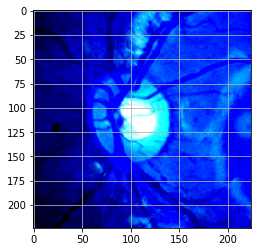

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


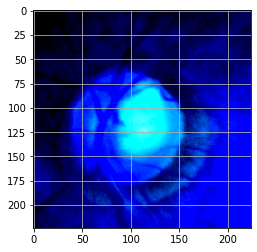

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 1.]


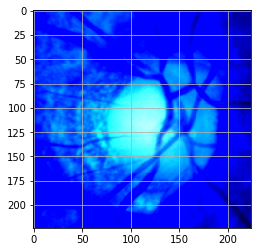

[0. 1.]


In [14]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
	test_size=0.2, random_state=seed)


plt.imshow(trainX[10])
plt.grid(None)
plt.show()
print(trainY[10])

plt.grid(None)

plt.imshow(testX[276])
plt.show()
print(testY[276])

plt.grid(None)

plt.imshow(testX[208])
plt.show()
print(testY[208])

In [15]:
# initialize the training data augmentation object

trainAug = ImageDataGenerator(
	rotation_range=40,
	zoom_range=0.2,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.2,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: [array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32)]


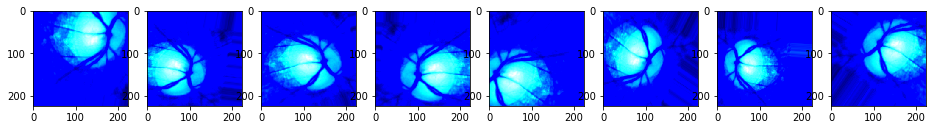

In [16]:
# visualize the different geometric transformations operated to the images

img_id = 600
cat_generator = trainAug.flow(trainX[img_id:img_id+1], 
 trainY[img_id:img_id+1], 
 batch_size=1) 
cat = [next(cat_generator) for i in range(0,8)] 
fig, ax = plt.subplots(1,8, figsize=(16, 6))

print('Labels:', [item[1][0] for item in cat]) 
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,8)]

In [62]:
# load ResNet50V2, ensuring the head FC layer sets are left off, while at
# the same time adjusting the size of the input image tensor to the
# network
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [63]:
# show a summary of the base model
print("[INFO] summary for base model...")
print(baseModel.summary())

[INFO] summary for base model...
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________

In [64]:
# construct the head of the model that will be placed on top of the
# the base model

layer_index = -1
headModel = baseModel.output

headModel = GlobalAveragePooling2D()(headModel)

headModel = Dense(2, activation="softmax")(headModel)
 
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [50]:
print(len(baseModel.layers))

175


In [51]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(baseModel.layers):
   print(i, layer.name)

0 input_4
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_148
5 pool1_pad
6 max_pooling2d_4
7 res2a_branch2a
8 bn2a_branch2a
9 activation_149
10 res2a_branch2b
11 bn2a_branch2b
12 activation_150
13 res2a_branch2c
14 res2a_branch1
15 bn2a_branch2c
16 bn2a_branch1
17 add_49
18 activation_151
19 res2b_branch2a
20 bn2b_branch2a
21 activation_152
22 res2b_branch2b
23 bn2b_branch2b
24 activation_153
25 res2b_branch2c
26 bn2b_branch2c
27 add_50
28 activation_154
29 res2c_branch2a
30 bn2c_branch2a
31 activation_155
32 res2c_branch2b
33 bn2c_branch2b
34 activation_156
35 res2c_branch2c
36 bn2c_branch2c
37 add_51
38 activation_157
39 res3a_branch2a
40 bn3a_branch2a
41 activation_158
42 res3a_branch2b
43 bn3a_branch2b
44 activation_159
45 res3a_branch2c
46 res3a_branch1
47 bn3a_branch2c
48 bn3a_branch1
49 add_52
50 activation_160
51 res3b_branch2a
52 bn3b_branch2a
53 activation_161
54 res3b_branch2b
55 bn3b_branch2b
56 activation_162
57 res3b_branch2c
58 bn3b_branch2c
59 add_53
60 activation_163
61 r

In [52]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
   layer.trainable = False

In [53]:
callbacks =  [EarlyStopping(monitor='val_loss', patience=20, verbose=1,  mode='auto'),
            ]

In [61]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [65]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)

lr_ = [1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
batch_ = [8, 12, 16]
opt = ['adam', 'sgd', 'rmsprop']
    

print("[INFO] compiling model...")
lr = 1e-5
momentum = 0.9
decay=1e-6
opt = SGD(lr=lr, momentum=momentum, decay=decay)
#opt = Adam(lr=lr)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
opt_name, _ = str(opt)[18:].split(' ', 1)
print(opt_name)

[INFO] compiling model...
SGD


In [66]:
epochs = 50
batch_size = 8

# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=epochs)

[INFO] training head...
Epoch 1/50
154/154 [==============================] - 35s 230ms/step - loss: 0.6507 - accuracy: 0.6365 - val_loss: 1.0698 - val_accuracy: 0.5114
Epoch 2/50
154/154 [==============================] - 23s 148ms/step - loss: 0.5316 - accuracy: 0.7490 - val_loss: 1.5416 - val_accuracy: 0.5077
Epoch 3/50
154/154 [==============================] - 23s 148ms/step - loss: 0.4782 - accuracy: 0.7897 - val_loss: 2.1762 - val_accuracy: 0.5017
Epoch 4/50
154/154 [==============================] - 23s 149ms/step - loss: 0.4547 - accuracy: 0.7979 - val_loss: 1.3135 - val_accuracy: 0.5077
Epoch 5/50
154/154 [==============================] - 23s 148ms/step - loss: 0.4393 - accuracy: 0.8044 - val_loss: 0.5523 - val_accuracy: 0.5981
Epoch 6/50
154/154 [==============================] - 23s 148ms/step - loss: 0.4310 - accuracy: 0.8003 - val_loss: 0.4242 - val_accuracy: 0.7726
Epoch 7/50
154/154 [==============================] - 23s 148ms/step - loss: 0.4131 - accuracy: 0.8134 - v

KeyboardInterrupt: 

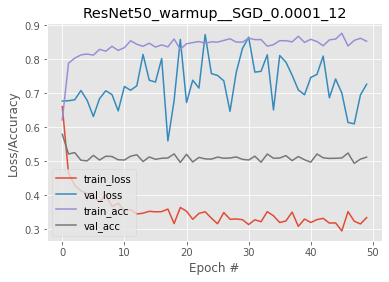

In [57]:
# plot the training loss and accuracy

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
title = "ResNet50_warmup_" + '_' + opt_name + '_' + str(lr) + '_' + str(batch_size)
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig('../evaluation/ResNet50V2/plots/' + title + '.png')

In [ ]:
# save history as a .npy file
np.save('../evaluation/ResNet50V2/history/' + title + '.npy', H)

In [174]:
model.save_weights("../models/ResNet50V2/weights_" + title + ".h5")

In [22]:
# evaluate the network

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=batch_size)
print(predictions)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1)))


[INFO] evaluating network...
[[0.60275346 0.3972465 ]
 [0.59968454 0.4003155 ]
 [0.6152081  0.38479188]
 [0.6073085  0.3926915 ]
 [0.6060884  0.39391157]
 [0.6074744  0.39252564]
 [0.61586505 0.38413495]
 [0.61507505 0.3849249 ]
 [0.61124927 0.38875076]
 [0.626561   0.37343895]
 [0.60874707 0.3912529 ]
 [0.6303674  0.36963263]
 [0.61298925 0.38701078]
 [0.6110163  0.3889837 ]
 [0.6031534  0.3968466 ]
 [0.61176944 0.38823062]
 [0.6003763  0.39962372]
 [0.63827693 0.36172312]
 [0.6125175  0.38748252]
 [0.6207922  0.3792078 ]
 [0.60602325 0.39397678]
 [0.60556626 0.39443374]
 [0.63196254 0.36803746]
 [0.63835245 0.36164755]
 [0.62990606 0.3700939 ]
 [0.6261735  0.3738265 ]
 [0.6014     0.39859998]
 [0.6133156  0.38668442]
 [0.60785455 0.39214545]
 [0.6200534  0.37994656]
 [0.59142053 0.40857944]
 [0.6065643  0.3934357 ]
 [0.62775034 0.37224966]
 [0.62363535 0.37636468]
 [0.6240037  0.37599632]
 [0.6092822  0.39071783]
 [0.6237321  0.3762679 ]
 [0.6109374  0.38906264]
 [0.60002536 0.399974

/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
score = model.evaluate(testX, testY,batch_size=32, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.27358651358911523
Test accuracy: 0.8673139214515686


In [93]:
baseModel2 = ResNet50V2(weights=None, include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

layer_index = -1
headModel2 = baseModel2.layers[layer_index].output
headModel2 = GlobalAveragePooling2D()(headModel2)

# let's add a fully-connected layer
hidden_units = 512
dropout_rate = 0.5

#headModel2 = Dense(hidden_units, activation='relu')(headModel2)
headModel = Dropout(dropout_rate)(headModel)
headModel2 = Dense(2, activation="softmax")(headModel2)
 
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model2 = Model(inputs=baseModel2.input, outputs=headModel2)

In [94]:
model2.load_weights("../models/ResNet50V2/weights_ResNet50V2_warmup__-1_0.5_SGD_1e-05_0.9_1e-06_8.h5")

In [95]:
for layer in model2.layers:
   layer.trainable = True

In [96]:
lr = 1e-4
momentum = 0.9
decay=1e-6
opt = SGD(lr=lr, momentum=momentum, decay=decay)

model2.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [97]:
model2.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [98]:
# initialize the training data augmentation object

trainAug2 = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug2 = ImageDataGenerator()

In [99]:
epochs = 100
batch_size = 16

# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model2.fit_generator(
	trainAug2.flow(trainX, trainY, batch_size=batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=valAug2.flow(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=epochs)

[INFO] training head...
Epoch 1/100
72/72 [==============================] - 26s 356ms/step - loss: 0.4370 - accuracy: 0.8091 - val_loss: 0.5398 - val_accuracy: 0.7317
Epoch 2/100
72/72 [==============================] - 14s 193ms/step - loss: 0.4097 - accuracy: 0.8231 - val_loss: 0.5479 - val_accuracy: 0.7966
Epoch 3/100
72/72 [==============================] - 14s 194ms/step - loss: 0.3714 - accuracy: 0.8354 - val_loss: 0.7087 - val_accuracy: 0.8121
Epoch 4/100
72/72 [==============================] - 14s 196ms/step - loss: 0.3844 - accuracy: 0.8249 - val_loss: 0.3775 - val_accuracy: 0.8305
Epoch 5/100
72/72 [==============================] - 14s 197ms/step - loss: 0.3581 - accuracy: 0.8415 - val_loss: 0.4613 - val_accuracy: 0.8531
Epoch 6/100
72/72 [==============================] - 14s 195ms/step - loss: 0.3530 - accuracy: 0.8398 - val_loss: 0.2344 - val_accuracy: 0.8559
Epoch 7/100
72/72 [==============================] - 14s 196ms/step - loss: 0.3446 - accuracy: 0.8371 - val_loss

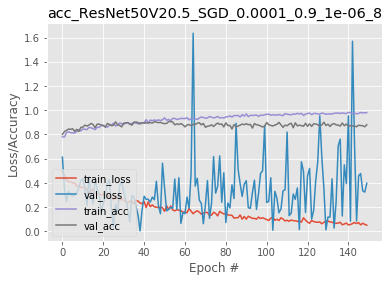

In [190]:
# plot the training loss and accuracy

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
title = "acc_ResNet50V2" + str(dropout_rate) + '_' + opt_name + '_' + str(lr) + '_' + str(momentum) + '_' + str(decay) + '_' + str(batch_size)
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig('../evaluation/ResNet50V2/plots/' + title + '.png')

In [188]:
score = model.evaluate(testX, testY,batch_size=32, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.413867968331523
Test accuracy: 0.8808290362358093


In [189]:
# evaluate the network

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=batch_size)
report = classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), output_dict=False)
print(report)


[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       209
           1       0.83      0.94      0.88       177

    accuracy                           0.88       386
   macro avg       0.88      0.89      0.88       386
weighted avg       0.89      0.88      0.88       386



In [200]:
# save model and architecture to single file
model.save("../models/ResNet50V2/ResNet50V2_fine_tuned_model" + title + ".h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model1 = load_model("../models/ResNet50V2/ResNet50V2_fine_tuned_model" + title + ".h5")